# Notebook to Generate ClimKern Manuscript Plots

By: Ty Janoski

## Setup

In [37]:
# import statements
import xarray as xr
import climkern as ck
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import warnings
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# make figures pdfs
%config Inlinebackend.figure_format = "pdf"

# suppress erroneous xESMF warnings about C/F contiguity
warnings.filterwarnings("ignore", message="Input array is not C_CONTIGUOUS. Will affect performance.")

# suppress RuntimeWarning that arises from trying to take mean/std of nan slice
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice.")

In [10]:
# Read in sample CESM data
ctrl, pert = ck.tutorial_data("ctrl"), ck.tutorial_data("pert")

# Read in effective radiative forcing
erf = ck.tutorial_data("ERF")

In [20]:
# A useful function
def _get_mean_and_std(da):
    mean = da.mean(dim=["lon", "time", "kern"], skipna=True)
    std = da.mean(dim=["lon", "time"], skipna=True).std(dim="kern", skipna=True)
    return (mean, std)

## Testing & Tutorial Values

### Temperature feedbacks

In [5]:
LR, Planck = ck.calc_T_feedbacks(
    ctrl.T, ctrl.TS, ctrl.PS, pert.T, pert.TS, pert.PS, pert.TROP_P, kern="GFDL"
)
dTS_glob_avg = ck.spat_avg(pert.TS - ctrl.TS)
print(
    "The global average lapse rate feedback is {val:.2f} W/m^2/K.".format(
        val=(ck.spat_avg(LR) / dTS_glob_avg).mean()
    )
)
print(
    "The global average Planck feedback is {val:.2f} W/m^2/K.".format(
        val=(ck.spat_avg(Planck) / dTS_glob_avg).mean()
    )
)

The global average lapse rate feedback is -0.41 W/m^2/K.
The global average Planck feedback is -3.12 W/m^2/K.


### Water vapor & albedo feedbacks

In [6]:
q_lw, q_sw = ck.calc_q_feedbacks(
    ctrl.Q, ctrl.T, ctrl.PS, pert.Q, pert.PS, pert.TROP_P, kern="GFDL", method=1
)
alb = ck.calc_alb_feedback(ctrl.FSUS, ctrl.FSDS, pert.FSUS, pert.FSDS, kern="GFDL")

print(
    "The global average water vapor feedback is {val:.2f} W/m^2/K.".format(
        val=(ck.spat_avg(q_lw + q_sw) / dTS_glob_avg).mean()
    )
)
print(
    "The global average surface albedo feedback is {val:.2f} W/m^2/K.".format(
        val=(ck.spat_avg(alb) / dTS_glob_avg).mean()
    )
)

The global average water vapor feedback is 1.44 W/m^2/K.
The global average surface albedo feedback is 0.38 W/m^2/K.


### Cloud feedbacks

In [9]:
# Calculate pre-requisite values for cloud feedbacks
# Cloud radiative effect
dCRE_LW = ck.calc_dCRE_LW(ctrl.FLNT, pert.FLNT, ctrl.FLNTC, pert.FLNTC)
dCRE_SW = ck.calc_dCRE_SW(ctrl.FSNT, pert.FSNT, ctrl.FSNTC, pert.FSNTC)

# clear-sky feedbacks
LR_cs, Planck_cs = ck.calc_T_feedbacks(
    ctrl.T,
    ctrl.TS,
    ctrl.PS,
    pert.T,
    pert.TS,
    pert.PS,
    pert.TROP_P,
    kern="GFDL",
    sky="clear-sky",
)
q_lw_cs, q_sw_cs = ck.calc_q_feedbacks(
    ctrl.Q,
    ctrl.T,
    ctrl.PS,
    pert.Q,
    pert.PS,
    pert.TROP_P,
    kern="GFDL",
    method=1,
    sky="clear-sky",
)
alb_cs = ck.calc_alb_feedback(
    ctrl.FSUS, ctrl.FSDS, pert.FSUS, pert.FSDS, kern="GFDL", sky="clear-sky"
)

In [11]:
cld_lw = ck.calc_cloud_LW(
    LR + Planck, LR_cs + Planck_cs, q_lw, q_lw_cs, dCRE_LW, erf.erf_lwas, erf.erf_lwcs
)
cld_sw = ck.calc_cloud_SW(
    alb, alb_cs, q_sw, q_sw_cs, dCRE_SW, erf.erf_swas, erf.erf_swcs
)

print(
    "The global average SW cloud feedback is {val:.2f} W/m^2/K.".format(
        val=(ck.spat_avg(cld_sw) / dTS_glob_avg).mean()
    )
)
print(
    "The global average LW cloud feedback is {val:.2f} W/m^2/K.".format(
        val=(ck.spat_avg(cld_lw) / dTS_glob_avg).mean()
    )
)

The global average SW cloud feedback is 0.38 W/m^2/K.
The global average LW cloud feedback is 0.03 W/m^2/K.


## Kernel-only comparison

In [13]:
# read in all kernels
kernels_list = [
    "BMRC",
    "CAM3",
    "CAM5",
    "CloudSat",
    "ECHAM6",
    "ECMWF-RRTM",
    "GFDL",
    "HadGEM2",
    "HadGEM3-GA7.1",
    "ERA5",
    "CERES",
]

kern_da = xr.DataArray(kernels_list, name="kern")
TOA_kerns_orig = [ck.util.get_kern(k) for k in kernels_list]
plevs = np.array(
    [
        1000,
        925,
        850,
        700,
        600,
        500,
        400,
        300,
        250,
        200,
        150,
        100,
        70,
        50,
        30,
        20,
        10,
        5,
        1,
    ]
)
# note that we are not combining them into a dataset yet because they have
# different horizontal grids

In [16]:
# path to where kernels are stored on my machine
path = "/home/janoski/climkern/climkern/data/tutorial_data/"
ctrl_ps = xr.open_dataset(path + "ctrl.nc").PS / 100
ctrl_ps.attrs["units"] = "hPa"

# iterate through the kernels
TOA_kerns_rg = []
for t, i in zip(TOA_kerns_orig, kernels_list):
    print(i)
    if t.plev.units in ["Pa"]:
        t["plev"] = t.plev / 100
        t.plev.attrs["units"] = "hPa"
    elif t.plev.units in ["millibars"]:
        t.plev.attrs["units"] = "hPa"

    # not all kernels mask their values below the surface

    # make regridder
    # note that skipna=True to avoid NaN's bleeding into interpolation
    regridder = xe.Regridder(
        t, ctrl_ps, method="bilinear", periodic=True, extrap_method="nearest_s2d"
    )
    kern_regrid = regridder(t, keep_attrs=True, skipna=True).interp(
        plev=plevs, kwargs={"fill_value": "extrapolate"}
    )

    # overwrite time axis
    kern_regrid["time"] = np.arange(1, 13, 1)

    # append regridded kernel to list
    TOA_kerns_rg.append(kern_regrid)

# combine kernels into one dataset with kernel dimension
TOA_kerns_rg = xr.concat(TOA_kerns_rg, dim=kern_da).rename({"dim_0": "kern"})

BMRC
CAM3
CAM5
CloudSat
ECHAM6
ECMWF-RRTM
GFDL
HadGEM2
HadGEM3-GA7.1
ERA5
CERES


In [17]:
# mask values below climatological surface
TOA_kerns_rg["lw_t"] = TOA_kerns_rg.lw_t.where(TOA_kerns_rg.plev < ctrl_ps)
TOA_kerns_rg["lw_q"] = TOA_kerns_rg.lw_q.where(TOA_kerns_rg.plev < ctrl_ps)
TOA_kerns_rg["sw_q"] = TOA_kerns_rg.sw_q.where(TOA_kerns_rg.plev < ctrl_ps)

TOA_kerns_rg["lwclr_t"] = TOA_kerns_rg.lwclr_t.where(TOA_kerns_rg.plev < ctrl_ps)
TOA_kerns_rg["lwclr_q"] = TOA_kerns_rg.lwclr_q.where(TOA_kerns_rg.plev < ctrl_ps)
TOA_kerns_rg["swclr_q"] = TOA_kerns_rg.swclr_q.where(TOA_kerns_rg.plev < ctrl_ps)

In [21]:
# Get kernel means and standard deviations
t_as_mean, t_as_std = _get_mean_and_std(TOA_kerns_rg.lw_t)
qlw_as_mean, qlw_as_std = _get_mean_and_std(TOA_kerns_rg.lw_q)
qsw_as_mean, qsw_as_std = _get_mean_and_std(TOA_kerns_rg.sw_q)
ts_as_mean, ts_as_std = _get_mean_and_std(TOA_kerns_rg.lw_ts)
alb_as_mean, alb_as_std = _get_mean_and_std(TOA_kerns_rg.sw_a)

t_cs_mean, t_cs_std = _get_mean_and_std(TOA_kerns_rg.lwclr_t)
qlw_cs_mean, qlw_cs_std = _get_mean_and_std(TOA_kerns_rg.lwclr_q)
qsw_cs_mean, qsw_cs_std = _get_mean_and_std(TOA_kerns_rg.swclr_q)
ts_cs_mean, ts_cs_std = _get_mean_and_std(TOA_kerns_rg.lwclr_ts)
alb_cs_mean, alb_cs_std = _get_mean_and_std(TOA_kerns_rg.swclr_a)

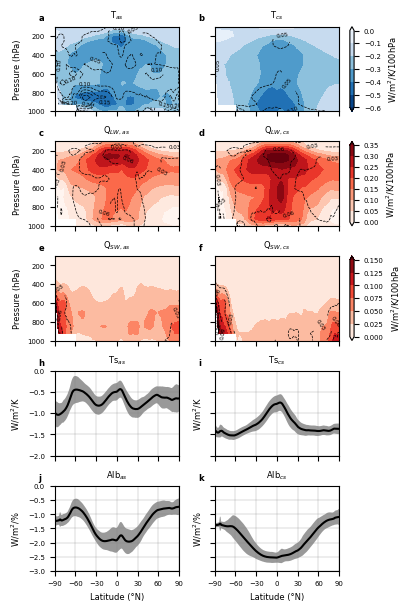

In [22]:
# Plot it up
fig, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(4, 6), layout="constrained", sharex=True, sharey="row"
)

for ax in axes.flatten():
    ax.tick_params(axis="both", labelsize=5)

# ======================================TEMP===================================

cp0 = axes[0, 0].contourf(
    t_as_mean.lat,
    t_as_mean.plev,
    t_as_mean,
    levels=np.arange(-0.6, 0.01, 0.1),
    cmap="Blues_r",
    extend="both",
)
axes[0, 0].set_title("T$_{as}$", fontsize=6)
cf0 = axes[0, 0].contour(
    t_as_std.lat,
    t_as_std.plev,
    t_as_std * 2,
    colors="black",
    levels=np.arange(0, 0.31, 0.05),
    linewidths=0.5,
    linestyles="dashed",
)
axes[0, 0].clabel(cf0, cf0.levels, inline=True, fontsize=4)
axes[0, 0].set_ylabel("Pressure (hPa)", fontsize=6)
axes[0, 0].set_ylim(100, 1000)

cp1 = axes[0, 1].contourf(
    t_cs_mean.lat,
    t_cs_mean.plev,
    t_cs_mean,
    levels=np.arange(-0.6, 0.01, 0.1),
    cmap="Blues_r",
    extend="both",
)
axes[0, 1].set_title("T$_{cs}$", fontsize=6)
cb1 = fig.colorbar(cp1, extend="min")
cb1.set_label(label=r"W/m$^2$/K/100hPa", fontsize=6)
cb1.ax.tick_params(labelsize=5)
cf1 = axes[0, 1].contour(
    t_cs_std.lat,
    t_cs_std.plev,
    t_cs_std * 2,
    colors="black",
    levels=np.arange(0, 0.31, 0.05),
    linewidths=0.5,
    linestyles="dashed",
)
axes[0, 1].clabel(cf1, cf1.levels, inline=True, fontsize=4)
axes[0, 1].set_ylim(100, 1000)

# =======================================WV====================================

cp2 = axes[1, 0].contourf(
    qlw_as_mean.lat,
    qlw_as_mean.plev,
    qlw_as_mean,
    levels=np.arange(0, 0.36, 0.05),
    extend="both",
    cmap="Reds",
)
axes[1, 0].set_title("Q$_{LW,as}$", fontsize=6)
cf2 = axes[1, 0].contour(
    qlw_as_std.lat,
    qlw_as_std.plev,
    qlw_as_std * 2,
    colors="black",
    levels=np.arange(0, 0.31, 0.03),
    linewidths=0.5,
    linestyles="dashed",
)
axes[1, 0].clabel(cf2, cf2.levels, inline=True, fontsize=4)
axes[1, 0].set_ylabel("Pressure (hPa)", fontsize=6)
axes[1, 0].set_ylim(100, 1000)

cp3 = axes[1, 1].contourf(
    qlw_cs_mean.lat,
    qlw_cs_mean.plev,
    qlw_cs_mean,
    levels=np.arange(0, 0.36, 0.05),
    extend="both",
    cmap="Reds",
)
axes[1, 1].set_title("Q$_{LW,cs}$", fontsize=6)
cb3 = fig.colorbar(cp3, extend="both")
cb3.set_label(label=r"W/m$^2$/K/100hPa", fontsize=6)
cb3.ax.tick_params(labelsize=5)
cf3 = axes[1, 1].contour(
    qlw_cs_std.lat,
    qlw_cs_std.plev,
    qlw_cs_std * 2,
    colors="black",
    levels=np.arange(0, 0.31, 0.03),
    linewidths=0.5,
    linestyles="dashed",
)
axes[1, 1].clabel(cf3, cf3.levels, inline=True, fontsize=4)
axes[1, 1].set_ylim(100, 1000)

cp4 = axes[2, 0].contourf(
    qsw_as_mean.lat,
    qsw_as_mean.plev,
    qsw_as_mean,
    levels=np.arange(0, 0.16, 0.025),
    cmap="Reds",
    extend="both",
)
axes[2, 0].set_title("Q$_{SW,as}$", fontsize=6)
cf4 = axes[2, 0].contour(
    qsw_as_std.lat,
    qsw_as_std.plev,
    qsw_as_std * 2,
    colors="black",
    levels=np.arange(0, 0.31, 0.03),
    linewidths=0.5,
    linestyles="dashed",
)
axes[2, 0].clabel(cf4, cf4.levels, inline=True, fontsize=4)
axes[2, 0].set_ylabel("Pressure (hPa)", fontsize=6)
axes[2, 0].set_ylim(100, 1000)

cp5 = axes[2, 1].contourf(
    qsw_cs_mean.lat,
    qsw_cs_mean.plev,
    qsw_cs_mean,
    levels=np.arange(0, 0.16, 0.025),
    cmap="Reds",
    extend="both",
)
axes[2, 1].set_title("Q$_{SW,cs}$", fontsize=6)
cb5 = fig.colorbar(cp5, extend="max")
cb5.set_label(label=r"W/m$^2$/K/100hPa", fontsize=6)
cb5.ax.tick_params(labelsize=5)
cf5 = axes[2, 1].contour(
    qsw_cs_std.lat,
    qsw_cs_std.plev,
    qsw_cs_std * 2,
    colors="black",
    levels=np.arange(0, 0.31, 0.03),
    linewidths=0.5,
    linestyles="dashed",
)
axes[2, 1].clabel(cf5, cf5.levels, inline=True, fontsize=4)
axes[2, 1].set_ylim(100, 1000)

# =====================================TS======================================

cp6 = axes[3, 0].plot(ts_as_mean.lat, ts_as_mean, color="black")
axes[3, 0].set_title("Ts$_{as}$", fontsize=6)
axes[3, 0].set_ylim(-2, 0)
axes[3, 0].set_ylabel("W/m$^2$/K", fontsize=6)
axes[3, 0].fill_between(
    ts_as_std.lat,
    ts_as_mean - ts_as_std * 2,
    ts_as_mean + ts_as_std * 2,
    color="black",
    alpha=0.4,
    edgecolor=None,
)

cp7 = axes[3, 1].plot(ts_cs_mean.lat, ts_cs_mean, color="black")
axes[3, 1].set_title("Ts$_{cs}$", fontsize=6)
axes[3, 1].set_ylim(-2, 0)
axes[3, 1].set_ylabel("W/m$^2$/K", fontsize=6)
axes[3, 1].fill_between(
    ts_cs_std.lat,
    ts_cs_mean - ts_cs_std * 2,
    ts_cs_mean + ts_cs_std * 2,
    color="black",
    alpha=0.4,
    edgecolor=None,
)


# =====================================Albedo======================================

cp8 = axes[4, 0].plot(alb_as_mean.lat, alb_as_mean, color="black")
axes[4, 0].set_ylim(-3, 0)
axes[4, 0].set_title("Alb$_{as}$", fontsize=6)
axes[4, 0].set_ylabel("W/m$^2$/%", fontsize=6)
axes[4, 0].fill_between(
    alb_as_std.lat,
    alb_as_mean - alb_as_std * 2,
    alb_as_mean + alb_as_std * 2,
    color="black",
    alpha=0.4,
    edgecolor=None,
)

axes[4, 0].set_xlabel("Latitude (°N)", fontsize=6)

cp9 = axes[4, 1].plot(alb_cs_mean.lat, alb_cs_mean, color="black")
axes[4, 1].set_ylim(-3, 0)
axes[4, 1].set_title("Alb$_{cs}$", fontsize=6)
axes[4, 1].set_ylabel("W/m$^2$/%", fontsize=6)
axes[4, 1].fill_between(
    alb_cs_std.lat,
    alb_cs_mean - alb_cs_std * 2,
    alb_cs_mean + alb_cs_std * 2,
    color="black",
    alpha=0.4,
    edgecolor=None,
)

axes[4, 1].set_xlabel("Latitude (°N)", fontsize=6)

for i, ax in enumerate(axes.flatten()):
    if i < 6 and i % 2 == 1:
        ax.invert_yaxis()
    if i >= 6:
        ax.grid(lw=0.2, color="gray")
    ax.set_xticks(np.arange(-90, 91, 30))
    ax.set_xlim(-90, 90)

letters = ["a", "b", "c", "d", "e", "f", "h", "i", "j", "k"]
for i, ax in enumerate(axes.flatten()):
    ax.text(
        -0.13, 1.07, letters[i], transform=ax.transAxes, fontsize=6, fontweight="bold"
    )
plt.savefig("Fig1-kernel-means-sds.pdf", bbox_inches="tight", dpi=600)
plt.show()

## Calculate sample feedbacks

In [23]:
# make a list of available kernels
kern_list = [
    "BMRC",
    "CAM3",
    "CAM5",
    "CloudSat",
    "CERES",
    "ECHAM6",
    "ECMWF-RRTM",
    "ERA5",
    "GFDL",
    "HadGEM2",
    "HadGEM3-GA7.1",
]

kerns = xr.DataArray(kern_list, coords={"kernel": kern_list}, name="kernel")

### Surface albedo feedbacks

In [24]:
alb_as = xr.concat(
    [
        ck.calc_alb_feedback(
            ctrl.FSUS, ctrl.FSDS, pert.FSUS, pert.FSDS, kern=k, sky="all-sky"
        )
        for k in kern_list
    ],
    dim=kerns,
)
alb_cs = xr.concat(
    [
        ck.calc_alb_feedback(
            ctrl.FSUS, ctrl.FSDS, pert.FSUS, pert.FSDS, kern=k, sky="clear-sky"
        )
        for k in kern_list
    ],
    dim=kerns,
)

### Temperature feedbacks

In [25]:
lr_as = []
pl_as = []
lr_cs = []
pl_cs = []
for k in kern_list:
    print(k)
    lr, pl = ck.calc_T_feedbacks(
        ctrl.T,
        ctrl.TS,
        ctrl.PS,
        pert.T,
        pert.TS,
        pert.PS,
        pert.TROP_P,
        kern=k,
        sky="all-sky",
        fixRH=False,
    )
    lr_as.append(lr)
    pl_as.append(pl)
    lr, pl = ck.calc_T_feedbacks(
        ctrl.T,
        ctrl.TS,
        ctrl.PS,
        pert.T,
        pert.TS,
        pert.PS,
        pert.TROP_P,
        kern=k,
        sky="clear-sky",
        fixRH=False,
    )
    lr_cs.append(lr)
    pl_cs.append(pl)

lr_as = xr.concat(lr_as, dim=kerns)
pl_as = xr.concat(pl_as, dim=kerns)
lr_cs = xr.concat(lr_cs, dim=kerns)
pl_cs = xr.concat(pl_cs, dim=kerns)

BMRC
CAM3
CAM5
CloudSat
CERES
ECHAM6
ECMWF-RRTM
ERA5
GFDL
HadGEM2
HadGEM3-GA7.1


### Water vapor feedbacks

In [26]:
qlw_as = []
qsw_as = []
qlw_cs = []
qsw_cs = []
for k in kern_list:
    print(k)
    qlw, qsw = ck.calc_q_feedbacks(
        ctrl.Q,
        ctrl.T,
        ctrl.PS,
        pert.Q,
        pert.PS,
        pert.TROP_P,
        kern=k,
        sky="all-sky",
        method=1,
    )
    qlw_as.append(qlw)
    qsw_as.append(qsw)
    qlw, qsw = ck.calc_q_feedbacks(
        ctrl.Q,
        ctrl.T,
        ctrl.PS,
        pert.Q,
        pert.PS,
        pert.TROP_P,
        kern=k,
        sky="clear-sky",
        method=1,
    )
    qlw_cs.append(qlw)
    qsw_cs.append(qsw)

qlw_as = xr.concat(qlw_as, dim=kerns)
qsw_as = xr.concat(qsw_as, dim=kerns)
qlw_cs = xr.concat(qlw_cs, dim=kerns)
qsw_cs = xr.concat(qsw_cs, dim=kerns)

BMRC
CAM3
CAM5
CloudSat
CERES
ECHAM6
ECMWF-RRTM
ERA5
GFDL
HadGEM2
HadGEM3-GA7.1


### Cloud feedbacks

In [27]:
# Calculate change in CRE
dCRE_LW = ck.calc_dCRE_LW(ctrl.FLNT, pert.FLNT, ctrl.FLNTC, pert.FLNTC)
dCRE_SW = ck.calc_dCRE_SW(ctrl.FSNT, pert.FSNT, ctrl.FSNTC, pert.FSNTC)

# Combine lapse rate and Planck feedbacks into one
t_as = lr_as + pl_as
t_cs = lr_cs + pl_cs

In [30]:
# adjustment method first
cld_lw = ck.calc_cloud_LW(
    t_as, t_cs, qlw_as, qlw_cs, dCRE_LW, erf.erf_lwas, erf.erf_lwcs
)
cld_sw = ck.calc_cloud_SW(
    alb_as, alb_cs, qsw_as, qsw_cs, dCRE_SW, erf.erf_swas, erf.erf_swcs
)

# residual method
cld_lw_res = ck.calc_cloud_LW_res(ctrl.FLNT, pert.FLNT, erf.erf_lwas, t_as, qlw_as)
cld_sw_res = ck.calc_cloud_SW_res(ctrl.FSNT, pert.FSNT, erf.erf_swas, qsw_as, alb_as)

## Feedback spatial maps

In [32]:
# Assemble data in a list
fbs = [
    i / dTS_glob_avg for i in [lr_as, pl_as, qlw_as + qsw_as, alb_as, cld_lw + cld_sw]
]

# Add a cyclic point
means = [
    add_cyclic_point(f.mean(dim=["time", "kernel"], skipna=True), coord=f.lon)[0]
    for f in fbs
]
sds = [
    add_cyclic_point(
        f.mean(dim="time", skipna=True).std(dim="kernel", skipna=True), coord=f.lon
    )[0]
    for f in fbs
]
lons = add_cyclic_point(lr_as, coord=lr_as.lon)[1]

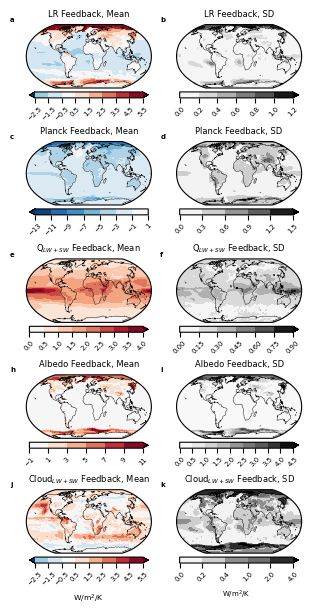

In [36]:
fig, axes = plt.subplots(
    nrows=5,
    ncols=2,
    subplot_kw={"projection": ccrs.Robinson()},
    figsize=(3, 6),
    layout="constrained",
)

for i, ax in enumerate(axes.flatten()):
    ax.coastlines(linewidth=0.3)

# ======================================================================================
# Lapse rate
# ======================================================================================

norm = colors.TwoSlopeNorm(vcenter=0, vmin=-5.5, vmax=5.5)
cf0 = axes[0, 0].contourf(
    lons,
    fbs[0].lat,
    means[0],
    transform=ccrs.PlateCarree(),
    levels=np.arange(-2.5, 5.6, 1),
    cmap="RdBu_r",
    extend="both",
    norm=norm,
)

cb0 = fig.colorbar(cf0, orientation="horizontal", shrink=0.95)
cb0.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
axes[0, 0].set_title("LR Feedback, Mean", fontsize=6)

cf1 = axes[0, 1].contourf(
    lons,
    fbs[0].lat,
    sds[0] * 2,
    transform=ccrs.PlateCarree(),
    levels=np.arange(0, 1.21, 0.2),
    cmap="Grays",
    extend="max",
)
cb1 = fig.colorbar(cf1, orientation="horizontal", shrink=0.95)
cb1.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
# cb1.set_label(label='W/m$^2$/K',fontsize=5)
axes[0, 1].set_title("LR Feedback, SD", fontsize=6)

# ======================================================================================
# Planck
# ======================================================================================

norm = colors.TwoSlopeNorm(vcenter=0, vmin=-13, vmax=1)
cf2 = axes[1, 0].contourf(
    lons,
    fbs[1].lat,
    means[1],
    transform=ccrs.PlateCarree(),
    levels=np.arange(-13, 1.1, 2),
    cmap="RdBu_r",
    extend="min",
    norm=norm,
)
cb2 = fig.colorbar(cf2, orientation="horizontal", shrink=0.95)
cb2.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
axes[1, 0].set_title("Planck Feedback, Mean", fontsize=6)

cf3 = axes[1, 1].contourf(
    lons,
    fbs[1].lat,
    sds[1] * 2,
    transform=ccrs.PlateCarree(),
    levels=np.arange(0, 1.51, 0.3),
    cmap="Grays",
    extend="max",
)
cb3 = fig.colorbar(cf3, orientation="horizontal", shrink=0.95)
cb3.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
axes[1, 1].set_title("Planck Feedback, SD", fontsize=6)

# ======================================================================================
# WV feedback
# ======================================================================================

norm = colors.TwoSlopeNorm(vcenter=0.25, vmin=0, vmax=4)
cf4 = axes[2, 0].contourf(
    lons,
    fbs[2].lat,
    means[2],
    transform=ccrs.PlateCarree(),
    levels=np.arange(0, 4.1, 0.5),
    cmap="RdBu_r",
    extend="max",
    norm=norm,
)
cb4 = fig.colorbar(cf4, orientation="horizontal", shrink=0.95)
cb4.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
axes[2, 0].set_title("Q$_{LW+SW}$ Feedback, Mean", fontsize=6)

cf5 = axes[2, 1].contourf(
    lons,
    fbs[2].lat,
    sds[2] * 2,
    transform=ccrs.PlateCarree(),
    levels=np.arange(0, 1.0, 0.15),
    cmap="Grays",
    extend="max",
)
cb5 = fig.colorbar(cf5, orientation="horizontal", shrink=0.95)
cb5.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
axes[2, 1].set_title("Q$_{LW+SW}$ Feedback, SD", fontsize=6)

# ======================================================================================
# Surface albedo feedback
# ======================================================================================

norm = colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=11)
cf6 = axes[3, 0].contourf(
    lons,
    fbs[3].lat,
    means[3],
    transform=ccrs.PlateCarree(),
    levels=np.arange(-1, 11.1, 2),
    cmap="RdBu_r",
    extend="max",
    norm=norm,
)
cb6 = fig.colorbar(cf6, orientation="horizontal", shrink=0.95)
cb6.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
axes[3, 0].set_title("Albedo Feedback, Mean", fontsize=6)

cf7 = axes[3, 1].contourf(
    lons,
    fbs[3].lat,
    sds[3] * 2,
    transform=ccrs.PlateCarree(),
    levels=np.arange(0, 5.0, 0.5),
    cmap="Grays",
    extend="max",
)
cb7 = fig.colorbar(cf7, orientation="horizontal", shrink=0.95)
cb7.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
axes[3, 1].set_title("Albedo Feedback, SD", fontsize=6)

# ======================================================================================
# Cloud feedback
# ======================================================================================

norm = colors.TwoSlopeNorm(vcenter=0, vmin=-5.5, vmax=5.5)
cf8 = axes[4, 0].contourf(
    lons,
    fbs[4].lat,
    means[4],
    transform=ccrs.PlateCarree(),
    levels=np.arange(-2.5, 5.6, 1),
    cmap="RdBu_r",
    extend="both",
    norm=norm,
)
cb8 = fig.colorbar(cf8, orientation="horizontal", shrink=0.95)
cb8.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
cb8.set_label(label="W/m$^2$/K", fontsize=5.5)
axes[4, 0].set_title("Cloud$_{LW+SW}$ Feedback, Mean", fontsize=6)

norm = colors.TwoSlopeNorm(vcenter=0.5, vmin=0, vmax=4)
cf9 = axes[4, 1].contourf(
    lons,
    fbs[4].lat,
    sds[4] * 2,
    transform=ccrs.PlateCarree(),
    levels=np.array([0, 0.2, 0.4, 1, 2, 4]),
    cmap="Grays",
    extend="max",
    norm=norm,
)
cb9 = fig.colorbar(cf9, orientation="horizontal", shrink=0.95)
cb9.ax.tick_params(labelsize=5, rotation=45, pad=1.5)
cb9.set_label(label="W/m$^2$/K", fontsize=5)
axes[4, 1].set_title("Cloud$_{LW+SW}$ Feedback, SD", fontsize=6)

letters = ["a", "b", "c", "d", "e", "f", "h", "i", "j", "k"]
for i, ax in enumerate(axes.flatten()):
    ax.text(
        -0.13, 1.05, letters[i], transform=ax.transAxes, fontsize=5, fontweight="bold"
    )
plt.savefig("Fig2_feedback_spatial_maps.pdf")
plt.show()

## Zonal mean feedbacks

In [45]:
# Create custom discrete colormap
cmap = cm.get_cmap("gist_rainbow")
colors = cmap(np.linspace(0, 1, 12))
colors = np.append(
    np.insert(plt.rcParams["axes.prop_cycle"].by_key()["color"], 5, "#000000"), "maroon"
)
colors = np.append(colors, ["#FFFF00", "#000000"])

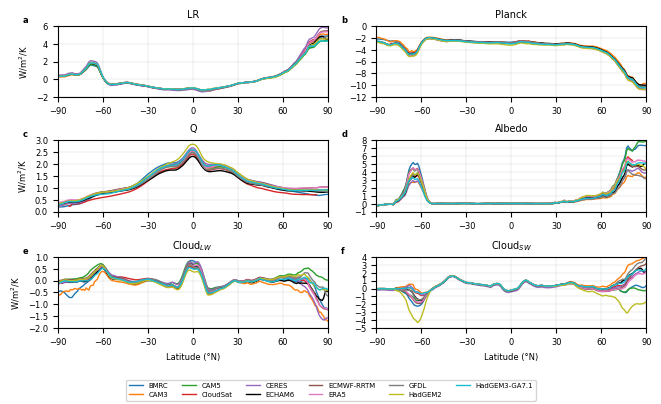

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6.5, 4), layout="constrained")
engine = fig.get_layout_engine()
engine.set(rect=(0, 0.08, 1, 0.9))

for ax in axes.flatten():
    ax.tick_params(axis="both", labelsize=6)
    ax.set_xticks(np.arange(-90, 91, 30))
    ax.set_xlim(-90, 90)
    ax.grid(linewidth=0.1, color="gray")

handles = []
for i, k in enumerate(kern_list):
    (l,) = axes[0, 0].plot(
        lr_as.lat,
        (lr_as / dTS_glob_avg).mean(dim=["lon", "time"]).sel(kernel=k),
        linewidth=1,
        alpha=1,
        label=k,
        color=colors[i],
    )
    axes[0, 1].plot(
        pl_as.lat,
        (pl_as / dTS_glob_avg).mean(dim=["lon", "time"]).sel(kernel=k),
        linewidth=1,
        alpha=1,
        color=colors[i],
    )
    axes[1, 0].plot(
        (qlw_as + qsw_as).lat,
        ((qlw_as + qsw_as.fillna(0)) / dTS_glob_avg)
        .mean(dim=["lon", "time"])
        .sel(kernel=k),
        linewidth=1,
        alpha=1,
        color=colors[i],
    )
    axes[2, 0].plot(
        cld_lw.lat,
        (cld_lw / dTS_glob_avg).mean(dim=["lon", "time"]).sel(kernel=k),
        linewidth=1,
        label=k,
        alpha=1,
        color=colors[i],
    )
    handles.append(l)
    axes[1, 1].plot(
        alb_as.lat,
        (alb_as / dTS_glob_avg).mean(dim=["lon", "time"]).sel(kernel=k),
        linewidth=1,
        alpha=1,
        label=k,
        color=colors[i],
    )
    axes[2, 1].plot(
        cld_sw.lat,
        (cld_sw / dTS_glob_avg).mean(dim=["lon", "time"]).sel(kernel=k),
        linewidth=1,
        alpha=1,
        label=k,
        color=colors[i],
    )

axes[0, 0].set_ylabel("W/m$^2$/K", fontsize=6)
axes[0, 0].set_ylim(-2, 6)
axes[0, 0].set_title("LR", fontsize=7)
# axes[0,1].set_ylabel('W/m$^2$/K',fontsize=6)
axes[0, 1].set_ylim(-12, 0)
axes[0, 1].set_yticks(np.arange(-12, 1, 2))
axes[0, 1].set_title("Planck", fontsize=7)
axes[1, 0].set_ylabel("W/m$^2$/K", fontsize=6)
axes[1, 0].set_ylim(0, 3)
axes[1, 0].set_yticks(np.arange(0, 3.1, 0.5))
axes[1, 0].set_title("Q", fontsize=7)
# axes[1,1].set_ylabel('Albedo (W/m$^2$/K)',fontsize=6)
axes[1, 1].set_ylim(-1, 8)
axes[1, 1].set_yticks(np.arange(-1, 9, 1))
axes[1, 1].set_title("Albedo", fontsize=7)
axes[2, 0].set_ylabel("W/m$^2$/K", fontsize=6)
axes[2, 0].set_ylim(-2, 1)
axes[2, 0].set_yticks(np.arange(-2, 1.1, 0.5))
axes[2, 0].set_title("Cloud$_{LW}$", fontsize=7)
# axes[2,1].set_ylabel('Cloud$_{SW}$ (W/m$^2$/K)',fontsize=6)
axes[2, 1].set_ylim(-5, 4)
axes[2, 1].set_yticks(np.arange(-5, 5, 1))
axes[2, 1].set_title("Cloud$_{SW}$", fontsize=7)

axes[2, 0].set_xlabel("Latitude (°N)", fontsize=6)
axes[2, 1].set_xlabel("Latitude (°N)", fontsize=6)

fig.legend(handles, kern_list, fontsize=5, ncols=6, loc="lower center")
# plt.subplots_adjust(bottom=0.13,hspace=0.35)

letters = ["a", "b", "c", "d", "e", "f"]
for i, ax in enumerate(axes.flatten()):
    ax.text(
        -0.13, 1.05, letters[i], transform=ax.transAxes, fontsize=6, fontweight="bold"
    )

plt.savefig("Fig3_feedback_zonal_means.pdf")
plt.show()

## Table of global average values

In [48]:
lr_means = ck.spat_avg((lr_as / dTS_glob_avg)).mean(dim="time").rename("LR")
lr_means = xr.concat(
    [
        lr_means,
        lr_means.mean().assign_coords(kernel="mean"),
        lr_means.std().assign_coords(kernel="std"),
    ],
    dim="kernel",
)
pl_means = (ck.spat_avg((pl_as / dTS_glob_avg)).mean(dim="time")).rename("Planck")
pl_means = xr.concat(
    [
        pl_means,
        pl_means.mean().assign_coords(kernel="mean"),
        pl_means.std().assign_coords(kernel="std"),
    ],
    dim="kernel",
)

q_means = (
    ck.spat_avg(((qsw_as + qlw_as) / dTS_glob_avg))
    .mean(dim="time")
    .rename(r"Q$_{total}$")
)
q_means = xr.concat(
    [
        q_means,
        q_means.mean().assign_coords(kernel="mean"),
        q_means.std().assign_coords(kernel="std"),
    ],
    dim="kernel",
)

alb_means = ck.spat_avg((alb_as / dTS_glob_avg)).mean(dim="time").rename("Albedo")
alb_means = xr.concat(
    [
        alb_means,
        alb_means.mean().assign_coords(kernel="mean"),
        alb_means.std().assign_coords(kernel="std"),
    ],
    dim="kernel",
)
cldsw_means = (
    ck.spat_avg((cld_sw / dTS_glob_avg)).mean(dim="time").rename("Cloud$_{SW,adj}$")
)
cldsw_means = xr.concat(
    [
        cldsw_means,
        cldsw_means.mean().assign_coords(kernel="mean"),
        cldsw_means.std().assign_coords(kernel="std"),
    ],
    dim="kernel",
)
cldlw_means = (
    ck.spat_avg((cld_lw / dTS_glob_avg)).mean(dim="time").rename("Cloud$_{LW,adj}$")
)
cldlw_means = xr.concat(
    [
        cldlw_means,
        cldlw_means.mean().assign_coords(kernel="mean"),
        cldlw_means.std().assign_coords(kernel="std"),
    ],
    dim="kernel",
)

cld_means = (
    ck.spat_avg(((cld_lw + cld_sw) / (dTS_glob_avg)))
    .mean(dim="time")
    .rename("Cloud$_{total,adj}$")
)
cld_means = xr.concat(
    [
        cld_means,
        cld_means.mean().assign_coords(kernel="mean"),
        cld_means.std().assign_coords(kernel="std"),
    ],
    dim="kernel",
)

ds = xr.merge(
    [
        lr_means,
        pl_means,
        q_means,
        alb_means,
        cldsw_means,
        cldlw_means,
        cld_means,
        cldsw_means,
        cldlw_means,
        cld_means,
    ],
    fill_value=np.nan,
)

df = ds.to_dataframe()

In [49]:
df.round(decimals=2)

,LR,Planck,Q$_{total}$,Albedo,"Cloud$_{SW,adj}$","Cloud$_{LW,adj}$","Cloud$_{total,adj}$"
kernel,,,,,,,
BMRC,-0.41,-3.07,1.52,0.57,0.31,0.00,0.31
CAM3,-0.40,-2.99,1.48,0.32,0.51,-0.07,0.44
CAM5,-0.43,-3.16,1.48,0.54,0.28,0.10,0.38
CloudSat,-0.42,-3.02,1.34,0.43,0.39,0.02,0.40
CERES,-0.42,-3.14,1.54,0.36,0.27,0.06,0.33
ECHAM6,-0.39,-3.07,1.37,0.41,0.38,-0.01,0.37
ECMWF-RRTM,-0.38,-3.21,1.53,0.51,0.30,-0.00,0.30
ERA5,-0.37,-3.18,1.51,0.52,0.33,0.01,0.34
GFDL,-0.41,-3.12,1.44,0.38,0.38,0.03,0.42
